# GhazalGen: Deep Learning Poetry with Hafez Shirazi

Welcome to the Deep Learning Homework Notebook! In this notebook, we'll explore the fascinating world of natural language processing using deep learning techniques. Our dataset consists of the timeless ghazals of Hafez Shirazi, a renowned Persian poet whose words resonate through the ages. Through this notebook, you'll learn how to train a deep learning model to generate poetry in the style of Hafez, unlocking the secrets of his mystical verses.

***Hafez***

Hafez Shirazi, often referred to simply as 'Hafez', was a 14th-century Persian poet whose lyrical genius has captivated hearts for centuries. Born in Shiraz, Iran, Hafez is celebrated as one of the greatest poets in Persian literature, revered for his mastery of the ghazal form. His poetry, characterized by its profound spiritual insight, rich symbolism, and exquisite imagery, explores themes of love, mysticism, and the divine. Hafez's works continue to inspire and enchant readers worldwide, transcending time and cultural boundaries.

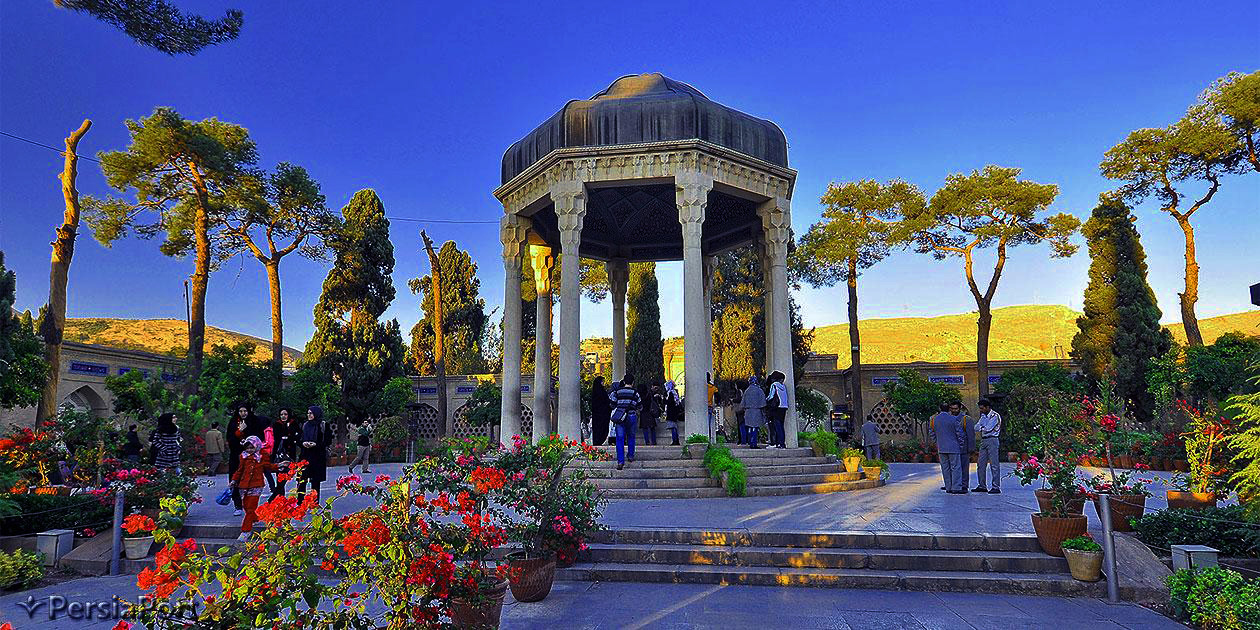

[https://www.iranmirrorbd.com/en/wp-content/uploads/2020/10/hafez.jpg](https://www.iranmirrorbd.com/en/wp-content/uploads/2020/10/hafez.jpg)


Please fill in the specified blanks or placeholders in the code cells below. You will find comments indicating where to input your code or data. Make sure to carefully read and follow the instructions provided. **You are only allowed to fill in the blanks.**


In [35]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import Counter
import warnings

import string

import matplotlib.pyplot as plt
import seaborn as sns

## Load data

This cell reads the contents of the 'divan.txt' file, which should be in the same directory as this notebook. The text will be stored in the variable 'document' for processing.


In [36]:
############################ Start Code #############################
with open('divan.txt', 'r', encoding='utf-8') as file:
    document = file.read()
############################ End Code ###############################
print(document[:70])

"O beautiful wine-bearer, bring fort h the cup and put it to my lips,"


## Data prepration

In this section, we preprocess the text data from the 'divan.txt' file to prepare it for training the model.

1. `text_to_word_list`: Converts the document into a list of words.
2. `clean_words`: Removes punctuation from the list of words.
3. `generate_vocabulary`: Generates the vocabulary from the list of words.
4. `build_word_dictionary`: Creates dictionaries for mapping words to integers and vice versa.
5. `generate_training_batches`: Generates batches of input-output pairs for training the model.

Make sure to understand each step before proceeding to the next section.


In [37]:
def text_to_word_list(document):
  hemistiches = document.split('\n')
  ############################ Start Code #############################
  words = []
  for hemistich in hemistiches:
      # Split on whitespace to get words
      hemistich_words = hemistich.strip().split()
      words.extend(hemistich_words)
  ############################ End Code ###############################
  return words

In [38]:
def clean_words(words):
  ############################ Start Code #############################
  cleaned_words = []
  # Define Persian-compatible punctuation (using string.punctuation for simplicity)
  translator = str.maketrans('', '', string.punctuation)
  for word in words:
      # Remove punctuation and keep only non-empty words
      cleaned_word = word.translate(translator).strip()
      if cleaned_word:
          cleaned_words.append(cleaned_word)
  words = cleaned_words
  ############################ End Code ###############################
  return words

In [39]:
def generate_vocabulary(words):
  ############################ Start Code #############################
  vocab = set(words)
  ############################ End Code ###############################
  return vocab

In [40]:
def build_word_dictionary(vocab):
  ############################ Start Code #############################
  vocab_to_int = {word: idx for idx, word in enumerate(vocab)}
  int_to_vocab = {idx: word for word, idx in vocab_to_int.items()}
  ############################ End Code ###############################
  return int_to_vocab, vocab_to_int

Now we perform the following steps:

1. Clean the words extracted from the document.
2. Generate the vocabulary from the cleaned words.
3. Build dictionaries for mapping words to integers and vice versa.

Your task is to complete the implementation by:
- Implementing the cleaning of words.
- Generating the vocabulary from the cleaned words.
- Building dictionaries for mapping words to integers and vice versa.

Once you have completed these tasks, you can proceed with the rest of the notebook.


In [41]:
############################ Start Code #############################
# Clean the words extracted from the document.
words = text_to_word_list(document)
words = clean_words(words)
# Generate the vocabulary from the cleaned words.
vocab = generate_vocabulary(words)
# Build dictionaries for mapping words to integers and vice versa.
int_to_vocab, vocab_to_int = build_word_dictionary(vocab)
############################ End Code ###############################

Please write enough explanations about how the following function works in your report file.

In [42]:
def generate_training_batches(words, vocab_to_int, batch_size, seq_size):
  word_ints = [vocab_to_int[word] for word in words]
  total_batches = len(word_ints) // (batch_size * seq_size)
  total_words = total_batches * batch_size * seq_size
  word_ints = word_ints[:total_words]

  Xs = np.array(word_ints)
  Ys = np.zeros_like(Xs)
  Ys[:-1] = Xs[1:]
  Ys[-1] = Xs[0]

  Xs = np.reshape(Xs, (total_batches*batch_size, seq_size))
  Ys= np.reshape(Ys, (total_batches*batch_size, seq_size))

  for i in range(0, Xs.shape[0], batch_size):
    yield Xs[i:i+batch_size, :], Ys[i:i+batch_size, :]

## Model

In this section, we'll build a simple Recurrent Neural Network (RNN) module using PyTorch. RNNs are a class of neural networks that are particularly effective for processing sequence data, making them well-suited for tasks like language modeling, time series prediction, and more. Our RNN module will consist of three main components: an embedding layer to convert words into dense vectors, an LSTM (Long Short-Term Memory) layer to capture sequential dependencies, and a fully connected layer to produce the final output. Throughout this section, we'll delve into the implementation details of each component, explore how they interact within the RNN architecture, and learn how to train and use the RNN module for various sequence processing tasks.



In [43]:
class RNNModule(nn.Module):
  # initialize RNN module
  def __init__(self, n_vocab, seq_size=32, embedding_size=64, lstm_size=64):
      # - n_vocab: The size of the vocabulary.
      # - seq_size: The size of the sequence.
      # - embedding_size: The size of the word embeddings.
      # - lstm_size: The size of the LSTM hidden state.
      super(RNNModule, self).__init__()
      self.seq_size = seq_size
      self.lstm_size = lstm_size

      ############################ Start Code #############################
      # Initialize the word embedding layer
      self.embedding = nn.Embedding(n_vocab, embedding_size)
      # Initialize the LSTM layer
      self.lstm = nn.LSTM(embedding_size, lstm_size, batch_first=True)
      # Initialize the fully connected layer
      self.fc = nn.Linear(lstm_size, n_vocab)
      ############################ End Code ###############################

  def forward(self, x, prev_state):
      ############################ Start Code #############################
      # Embed the input sequence
      embed = self.embedding(x)
      # Pass the embedded sequence through the LSTM layer
      lstm_out, state = self.lstm(embed, prev_state)
      # Pass the LSTM output through the fully connected layer
      logits = self.fc(lstm_out)
      ############################ End Code ###############################
      return logits, state

  def zero_state(self, batch_size):
      return (torch.zeros(1, batch_size, self.lstm_size),torch.zeros(1, batch_size, self.lstm_size))
    # The zero_state method initializes the hidden and cell state of the LSTM with zeros.

In [44]:
def generate_text(device, model, words, n_vocab, vocab_to_int, int_to_vocab, top_k=5):
  model.eval()

  state_h, state_c = model.zero_state(1)
  state_h = state_h.to(device)
  state_c = state_c.to(device)
  for w in words:
    ix = torch.tensor([[vocab_to_int[w]]]).to(device)
    output, (state_h, state_c) = net(ix, (state_h, state_c))

  _, top_ix = torch.topk(output[0], k=top_k)
  choices = top_ix.tolist()
  choice = np.random.choice(choices[0])

  words.append(int_to_vocab[choice])

  for _ in range(70):
    ix = torch.tensor([[choice]]).to(device)
    output, (state_h, state_c) = model(ix, (state_h, state_c))

    _, top_ix = torch.topk(output[0], k=top_k)
    choices = top_ix.tolist()
    choice = np.random.choice(choices[0])
    words.append(int_to_vocab[choice])

  return ' '.join(words)

In [45]:
def train_rnn(model, words, vocab_to_int, int_to_vocab, n_vocab, lr, num_epochs):
  ############################ Start Code #############################
  # Initialize optimizer and loss function
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()
  # Move model to device
  model.to(device)
  ############################ End Code ###############################
  iteration = 0

  for e in range(num_epochs):
      ############################ Start Code #############################
      # Initialize hidden and cell states
      state_h, state_c = model.zero_state(batch_size)
      state_h = state_h.to(device)
      state_c = state_c.to(device)
      # Generate training batches
      batches = generate_training_batches(words, vocab_to_int, batch_size, seq_size)
      ############################ End Code ###############################

      # Transfer data to GPU
      ############################ Start Code #############################
      model.train()  # Ensure model is in training mode
      ############################ End Code ###############################
      for x, y in batches:
          iteration += 1

          # Tell it we are in training mode
          model.train()

          # Reset all gradients
          optimizer.zero_grad()

          # Transfer data to GPU
          x = torch.tensor(x).to(device)
          y = torch.tensor(y).to(device)

          ############################ Start Code #############################
          # Forward pass
          logits, (state_h, state_c) = model(x, (state_h, state_c))
          ############################ End Code ###############################
          loss = criterion(logits.transpose(1, 2), y)

          state_h = state_h.detach()
          state_c = state_c.detach()

          loss_value = loss.item()

          # Perform back-propagation
          loss.backward(retain_graph=True)

          _ = torch.nn.utils.clip_grad_norm_(model.parameters(), gradients_norm)

          # Update the network's parameters
          optimizer.step()

          if iteration % 100 == 0:
              print('Epoch: {}/{}'.format(e+1, num_epochs), 'Iteration: {}'.format(iteration), 'Loss: {}'.format(loss_value))
  return model

## Train

In [46]:
batch_size = 256
seq_size = 32
embedding_size = 64
lstm_size = 64
gradients_norm = 5
lr = 0.001
num_epochs = 1000
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
############################ Start Code #############################
net = RNNModule(len(vocab), seq_size, embedding_size, lstm_size)
net = net.to(device)
net = train_rnn(net, words, vocab_to_int, int_to_vocab, len(vocab), lr, num_epochs)
############################ End Code ###############################

Epoch: 50/1000 Iteration: 100 Loss: 6.36818790435791
Epoch: 100/1000 Iteration: 200 Loss: 5.944416046142578
Epoch: 150/1000 Iteration: 300 Loss: 5.420466423034668
Epoch: 200/1000 Iteration: 400 Loss: 4.8971781730651855
Epoch: 250/1000 Iteration: 500 Loss: 4.406223297119141
Epoch: 300/1000 Iteration: 600 Loss: 3.9554545879364014
Epoch: 350/1000 Iteration: 700 Loss: 3.557532548904419
Epoch: 400/1000 Iteration: 800 Loss: 3.2195000648498535
Epoch: 450/1000 Iteration: 900 Loss: 2.9360134601593018
Epoch: 500/1000 Iteration: 1000 Loss: 2.6942944526672363
Epoch: 550/1000 Iteration: 1100 Loss: 2.481372117996216
Epoch: 600/1000 Iteration: 1200 Loss: 2.2903671264648438
Epoch: 650/1000 Iteration: 1300 Loss: 2.1143085956573486
Epoch: 700/1000 Iteration: 1400 Loss: 1.9531077146530151
Epoch: 750/1000 Iteration: 1500 Loss: 1.8038290739059448
Epoch: 800/1000 Iteration: 1600 Loss: 1.6669780015945435
Epoch: 850/1000 Iteration: 1700 Loss: 1.5400545597076416
Epoch: 900/1000 Iteration: 1800 Loss: 1.41924285

## generate text

In [48]:
############################ Start Code #############################
generated_text = generate_text(device, net, ['I'], len(vocab), vocab_to_int, int_to_vocab)
generated_text
############################ End Code ###############################

'I am wandering eyes never aware in the reed I will tell the soul was spoiled my head to kiss this path I was the cup again young flower benefit in my secrets divine nobody other who travel read Violin to sleep How can entertain away put the world the Beloved has no option we just I complain of His face and go ask me not I asked to leave me to'

## References


*  yet another notebook to make it solid: https://www.kaggle.com/ab971631/beginners-guide-to-text-generation-pytorch
*  and last one is a little advanced: https://www.kaggle.com/ankitjha/anyone-can-learn-text-generation
